Programming Assignment 1:
Data Preparation and Understanding

https://github.com/suprovapaul/DM_ProgrammingAssignment1

#Image Data Classification


Saving New_Dataset.zip to New_Dataset (6).zip
Archive:  New_Dataset.zip
replace dataset/New_Dataset/buildings/1001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dataset/New_Dataset/buildings/1001.jpg  
  inflating: dataset/New_Dataset/buildings/1012.jpg  
  inflating: dataset/New_Dataset/buildings/1058.jpg  
  inflating: dataset/New_Dataset/buildings/1064.jpg  
  inflating: dataset/New_Dataset/buildings/1093.jpg  
  inflating: dataset/New_Dataset/buildings/1107.jpg  
  inflating: dataset/New_Dataset/buildings/112.jpg  
  inflating: dataset/New_Dataset/buildings/1161.jpg  
  inflating: dataset/New_Dataset/buildings/1201.jpg  
  inflating: dataset/New_Dataset/buildings/1204.jpg  
  inflating: dataset/New_Dataset/buildings/1221.jpg  
  inflating: dataset/New_Dataset/buildings/1242.jpg  
  inflating: dataset/New_Dataset/buildings/1244.jpg  
  inflating: dataset/New_Dataset/buildings/139.jpg  
  inflating: dataset/New_Dataset/buildings/1413.jpg  
  inflating: dataset/New_Dataset

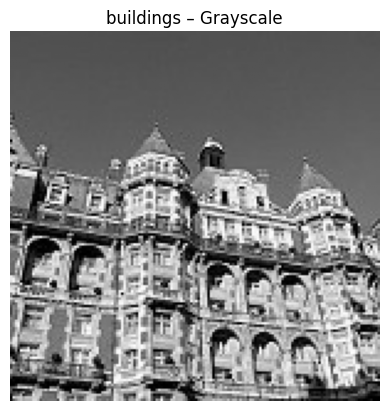

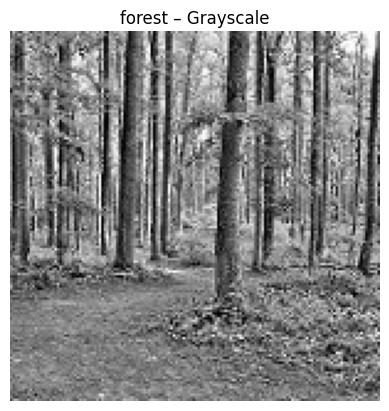

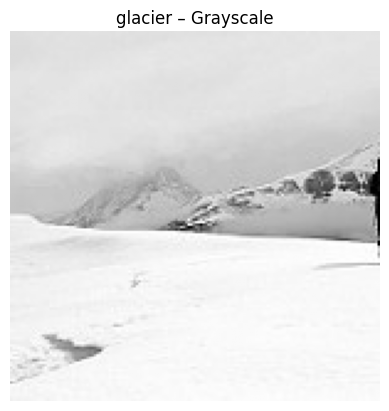

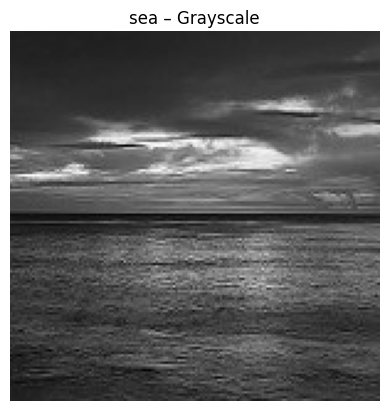

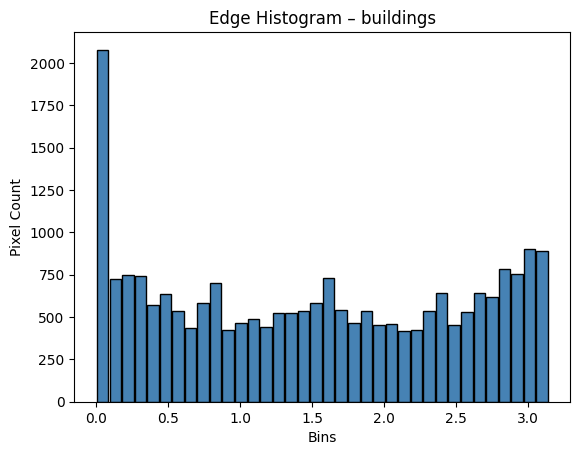

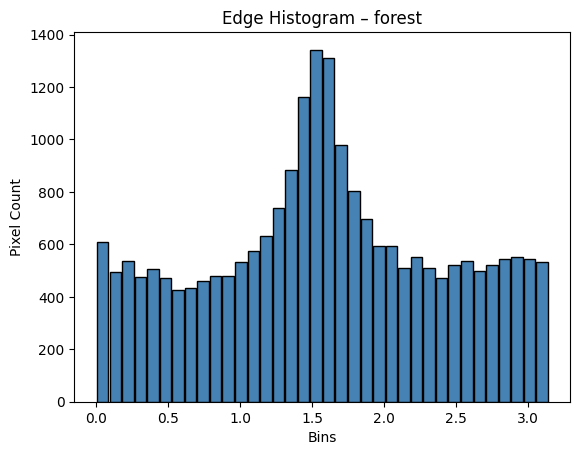

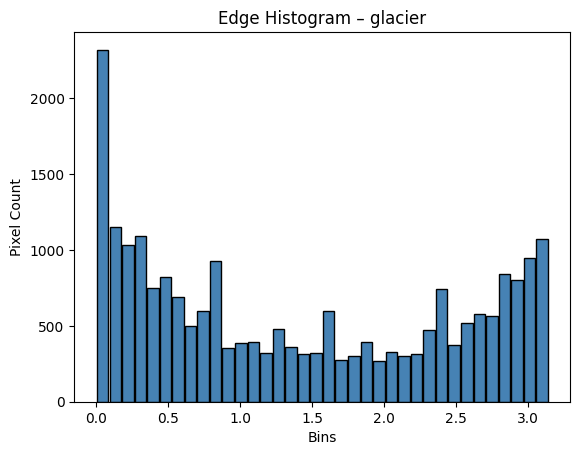

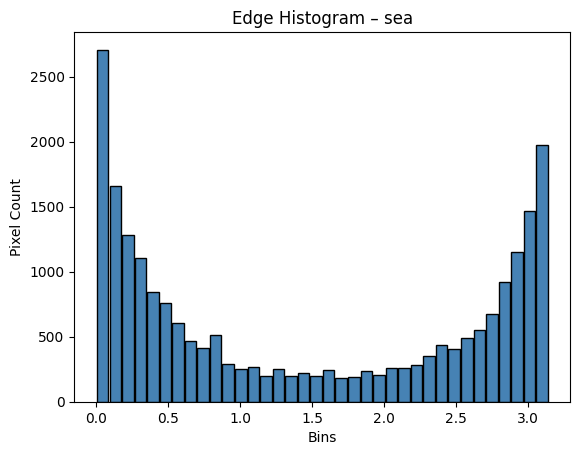

Comparing histograms: buildings vs forest
Euclidean distance : 2185.0771153439873
Manhattan distance : 8896.0
Cosine distance    : 0.14528084509524697


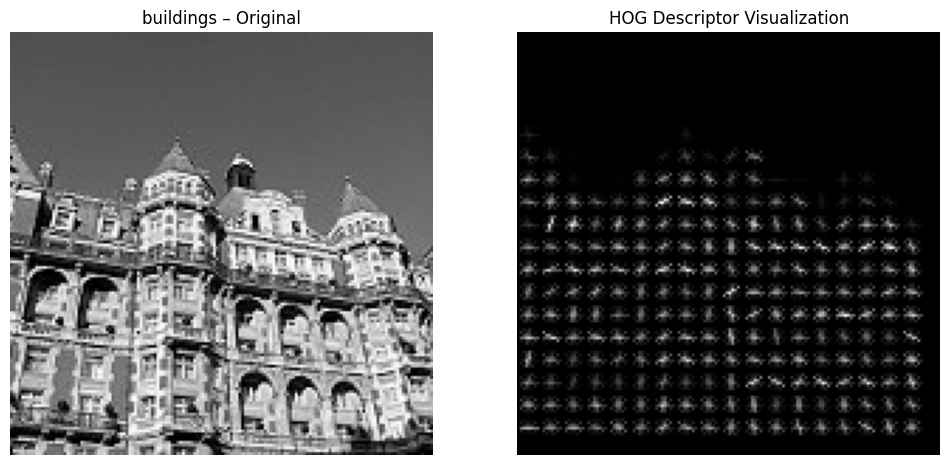

HOG feature vector length: 10404


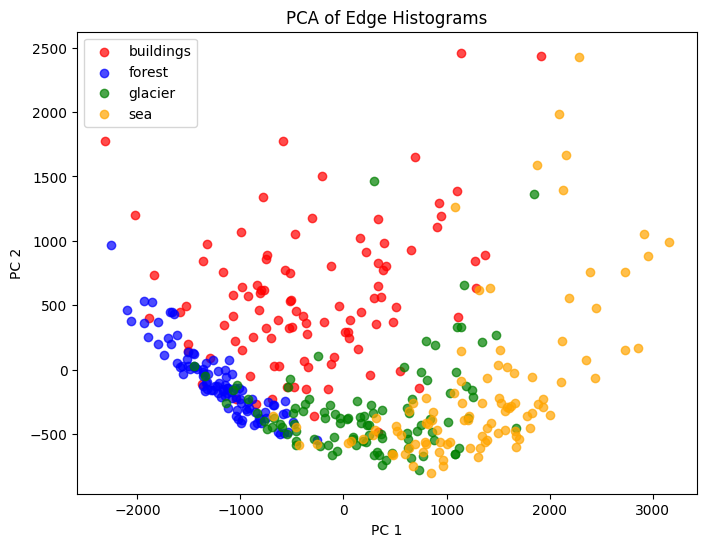

In [19]:
# Setup & Install Libraries
!pip install scikit-image scikit-learn matplotlib

import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, exposure
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_distances
from skimage.feature import hog
from sklearn.decomposition import PCA

# Upload zipped dataset from local machine
from google.colab import files
uploaded = files.upload()

# Unzip to a folder
!unzip New_Dataset.zip -d dataset


# Define the data directory
data_dir = "dataset/New_Dataset"
classes = sorted(os.listdir(data_dir))
print("Classes found:", classes)

# Check image counts
for cls in classes:
    count = len(os.listdir(os.path.join(data_dir, cls)))
    print(f"{cls}: {count} images")

# Pick 1 image from each class & convert to grayscale
# Link used: https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_rgb_to_gray.html

images = {}

for cls in classes:
    class_path = os.path.join(data_dir, cls)
    img_name = os.listdir(class_path)[0]        # take first image in each class
    img_path = os.path.join(class_path, img_name)

    img = io.imread(img_path)
    gray = color.rgb2gray(img) if img.ndim == 3 else img
    images[cls] = gray

    plt.imshow(gray, cmap='gray')
    plt.title(f"{cls} – Grayscale")
    plt.axis('off')
    plt.show()

# 6. Compute edge angle and edge histogram
# Link: https://scikit-image.org/docs/stable/api/skimage.exposure.html#skimage.exposure.histogram

def angle(dx, dy):
    """Angles between horizontal and vertical Sobel operators."""
    return np.mod(np.arctan2(dy, dx), np.pi)

edge_histograms = {}

for cls, I in images.items():
    # Sobel horizontal & vertical
    angle_sobel = angle(filters.sobel_h(I), filters.sobel_v(I))

    # 36-bin histogram of edge directions
    hist, bin_centers = exposure.histogram(angle_sobel, nbins=36)
    edge_histograms[cls] = hist

    # Plot histogram
    plt.figure()
    plt.bar(bin_centers, hist, width=0.08, color='steelblue', edgecolor='black')
    plt.title(f"Edge Histogram – {cls}")
    plt.xlabel("Bins")
    plt.ylabel("Pixel Count")
    plt.show()


# Compare two edge histograms
# Link: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.distance_metrics.html

cls1, cls2 = classes[0], classes[1]
h1 = edge_histograms[cls1].reshape(1, -1)
h2 = edge_histograms[cls2].reshape(1, -1)

print(f"Comparing histograms: {cls1} vs {cls2}")
print("Euclidean distance :", euclidean_distances(h1, h2)[0][0])
print("Manhattan distance :", manhattan_distances(h1, h2)[0][0])
print("Cosine distance    :", cosine_distances(h1, h2)[0][0])

# HOG Feature Descriptor
# Link: https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_hog.html

sample_cls = classes[0]
sample_img = images[sample_cls]

hog_features, hog_image = hog(sample_img,
                              pixels_per_cell=(8,8),
                              cells_per_block=(2,2),
                              visualize=True)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.imshow(sample_img, cmap='gray')
ax1.set_title(f"{sample_cls} – Original")
ax1.axis('off')

ax2.imshow(hog_image, cmap='gray')
ax2.set_title("HOG Descriptor Visualization")
ax2.axis('off')
plt.show()

print("HOG feature vector length:", len(hog_features))

# PCA Dimensionality Reduction on ALL Images
# Link: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

all_histograms = []
labels = []

# Convert every image in every class to edge histogram
for cls in classes:
    folder = os.path.join(data_dir, cls)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = io.imread(img_path)
        gray = color.rgb2gray(img) if img.ndim == 3 else img
        angle_sobel = angle(filters.sobel_h(gray), filters.sobel_v(gray))
        hist, _ = exposure.histogram(angle_sobel, nbins=36)
        all_histograms.append(hist)
        labels.append(cls)

all_histograms = np.array(all_histograms)

# Perform PCA to reduce from 36D -> 2D
pca = PCA(n_components=2)
hist_2d = pca.fit_transform(all_histograms)

# Plot PCA result with 4 colors
colors = ['red','blue','green','orange']
plt.figure(figsize=(8,6))

for i, cls in enumerate(classes):
    idx = [j for j,l in enumerate(labels) if l==cls]
    plt.scatter(hist_2d[idx,0], hist_2d[idx,1],
                label=cls, alpha=0.7, c=colors[i])

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA of Edge Histograms')
plt.legend()
plt.show()



Two classes (forest and sea) are clearly separable. Buildings are partly separable, and glacier overlaps with others.

#Text Data Classification


Saving train.json to train (4).json
Columns: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
Number of records: 3000
CountVectorizer shape: (3000, 9562)
TF-IDF shape: (3000, 9562)


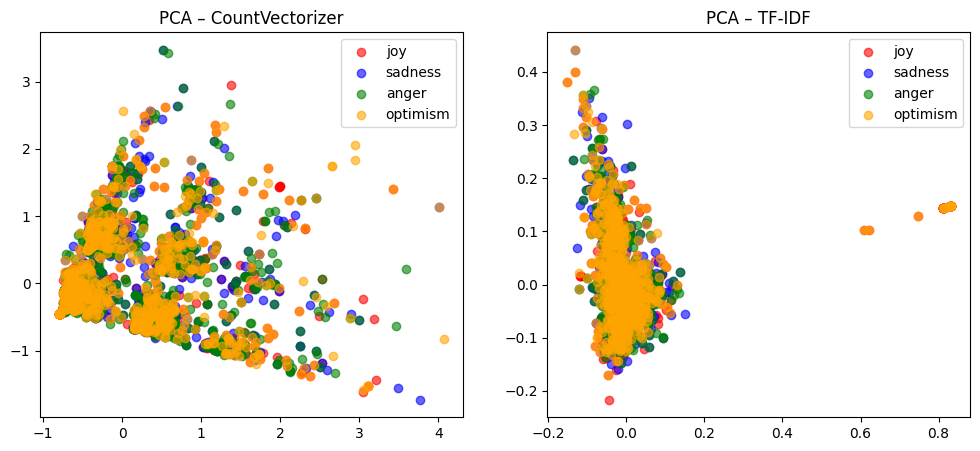

In [20]:
# Load JSON dataset
import pandas as pd
import json

# load training data into DataFrame

from google.colab import files
up = files.upload()
fname = next(iter(up.keys()))

data = pd.read_json("train.json", lines=True)

print("Columns:", data.columns.tolist())
print("Number of records:", len(data))

# Extract text & labels
texts = data["Tweet"]
labels = data[['anger','anticipation','disgust','fear','joy',
               'love','optimism','pessimism','sadness','surprise','trust']]

# CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

count_vec = CountVectorizer()
X_count = count_vec.fit_transform(texts)
print("CountVectorizer shape:", X_count.shape)

# TF-IDF
tfidf_vec = TfidfVectorizer()
X_tfidf = tfidf_vec.fit_transform(texts)
print("TF-IDF shape:", X_tfidf.shape)

# PCA with 4 selected classes
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# pick 4 classes
chosen = ["joy","sadness","anger","optimism"]
mask = labels[chosen].any(axis=1)
texts_sub = texts[mask]
labels_sub = labels[mask]

X_count_sub = count_vec.fit_transform(texts_sub)
X_tfidf_sub = tfidf_vec.fit_transform(texts_sub)

# reduce to 2D
pca_count = PCA(n_components=2).fit_transform(X_count_sub.toarray())
pca_tfidf = PCA(n_components=2).fit_transform(X_tfidf_sub.toarray())

colors = ['red','blue','green','orange']
plt.figure(figsize=(12,5))

# Count plot
plt.subplot(1,2,1)
for i,cls in enumerate(chosen):
    idx = labels_sub[cls] == True
    plt.scatter(pca_count[idx,0], pca_count[idx,1], label=cls, alpha=0.6, c=colors[i])
plt.title("PCA – CountVectorizer")
plt.legend()

# TF-IDF plot
plt.subplot(1,2,2)
for i,cls in enumerate(chosen):
    idx = labels_sub[cls] == True
    plt.scatter(pca_tfidf[idx,0], pca_tfidf[idx,1], label=cls, alpha=0.6, c=colors[i])
plt.title("PCA – TF-IDF")
plt.legend()

plt.show()


No class is fully visually separable in both plots. All four classes (joy, sadness, anger, optimism) overlap significantly.